 All necessary NLTK data downloaded successfully!
 Libraries imported successfully!
Mounted at /content/drive
 McDonald's reviews dataset loaded successfully!
 'label' column created from rating values.
Dataset shape: (33396, 11)
   reviewer_id  store_name              category  \
0            1  McDonald's  Fast food restaurant   
1            2  McDonald's  Fast food restaurant   
2            3  McDonald's  Fast food restaurant   
3            4  McDonald's  Fast food restaurant   
4            5  McDonald's  Fast food restaurant   

                                       store_address  latitude   longitude  \
0  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
1  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
2  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
3  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
4  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression Accuracy: 0.8162
MultinomialNB Accuracy: 0.8069
LinearSVC Accuracy: 0.8195
 Best model: LinearSVC with accuracy: 0.8195
 Model and vectorizer saved successfully!

 Testing the model with sample reviews...
Review Sentiment Analysis Results:
1. Review: The burger was delicious and the service was fast!
   Sentiment: POSITIVE (Confidence: 0.792)
--------------------------------------------------------------------------------
2. Review: The staff was rude and my order was wrong.
   Sentiment: NEGATIVE (Confidence: 0.618)
--------------------------------------------------------------------------------
3. Review: The fries were cold and the restaurant was dirty.
   Sentiment: NEGATIVE (Confidence: 0.726)
--------------------------------------------------------------------------------
4. Review: Great value meal and friendly service as always.
   Sentiment: POSITIVE (Confidence: 0.821)
--------------------------------------------------------------------------------
5. Revie

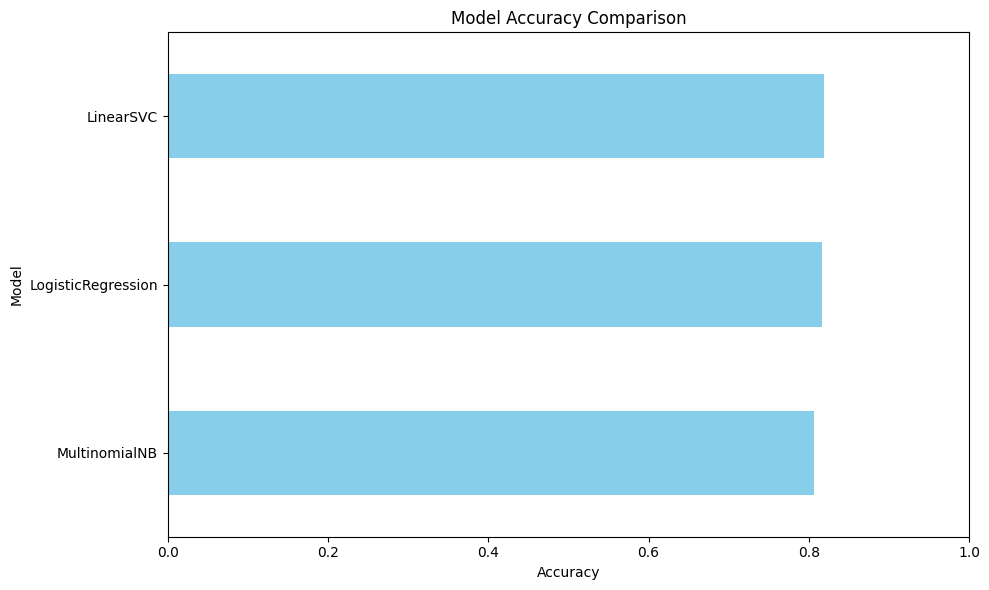


 McDonald's Sentiment Analysis Complete!
   model = joblib.load('/content/drive/MyDrive/data/mcdonalds_sentiment/model.joblib')
   vectorizer = joblib.load('/content/drive/MyDrive/data/mcdonalds_sentiment/vectorizer.joblib')


In [ ]:
"""McDonald's_Store_Reviews_Sentiment_Analysis"""

# Install required packages
!pip install -q nltk scikit-learn pandas matplotlib joblib

# Import libraries
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

# NLTK setup
import nltk
try:
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    print(" All necessary NLTK data downloaded successfully!")
except Exception as e:
    print(f" NLTK download error: {e}")
    raise e

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
RANDOM_STATE = 42

print(" Libraries imported successfully!")


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# --- Load McDonald's reviews dataset ---
try:
    df = pd.read_csv('/content/drive/MyDrive/data/McDonald_s_Reviews.csv', encoding='ISO-8859-1')
    print(" McDonald's reviews dataset loaded successfully!")

    # Create 'label' column if missing
    if 'label' not in df.columns and 'rating' in df.columns:
        df['label'] = df['rating'].apply(
            lambda x: 'POSITIVE' if str(x).startswith('4') or str(x).startswith('5')
            else 'NEGATIVE' if str(x).startswith('1') or str(x).startswith('2')
            else 'NEUTRAL'
        )
        print(" 'label' column created from rating values.")

except Exception as e:
    print(" Could not load McDonald's reviews dataset.")
    print("Error:", e)
    print("Creating a sample dataset for demonstration...")

    sample_reviews = [
        {"review": "The burger was amazing and the service was quick!", "rating": 5, "label": "POSITIVE"},
        {"review": "Food was cold and the staff was rude. Disappointing.", "rating": 1, "label": "NEGATIVE"},
        {"review": "Great value for money. Fries were perfect.", "rating": 4, "label": "POSITIVE"},
        {"review": "Waited too long in drive-thru. Not worth it.", "rating": 2, "label": "NEGATIVE"},
        {"review": "Clean restaurant and friendly staff. Will come back.", "rating": 5, "label": "POSITIVE"},
        {"review": "Parking lot is always full. Need more spaces.", "rating": 3, "label": "NEUTRAL"}
    ]
    df = pd.DataFrame(sample_reviews)

print(f"Dataset shape: {df.shape}")
print(df.head())

# --- Map labels to numeric for 3-class classification ---
def map_label_3class(x):
    x = str(x).lower()
    if x in ['positive', 'pos', 'p', '5', '4']:
        return 2  # POSITIVE
    elif x in ['negative', 'neg', 'n', '1', '2']:
        return 0  # NEGATIVE
    else:
        return 1  # NEUTRAL

df['label_num'] = df['label'].apply(map_label_3class)
df_3class = df.copy()
label_map_rev = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}

print("\nLabel distribution:")
print(df_3class['label'].value_counts())

# --- Text cleaning ---
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = [lemmatizer.lemmatize(t) for t in word_tokenize(text) if t not in STOPWORDS and len(t) > 1]
    return " ".join(tokens)

df_3class['clean_review'] = df_3class['review'].apply(clean_text)

# --- Train/Test split ---
X = df_3class['clean_review']
y = df_3class['label_num']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# --- TF-IDF Vectorization ---
vectorizer = TfidfVectorizer(max_features=8000, min_df=3, max_df=0.9, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# --- Model training ---
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, multi_class='multinomial'),
    'MultinomialNB': MultinomialNB(),
    'LinearSVC': LinearSVC(max_iter=5000, random_state=RANDOM_STATE, multi_class='ovr')
}

results = {}
for name, model in models.items():
    model.fit(X_train_vec, y_train)
    preds = model.predict(X_test_vec)
    acc = accuracy_score(y_test, preds)
    results[name] = {'model': model, 'accuracy': acc}
    print(f"{name} Accuracy: {acc:.4f}")

best_name = max(results, key=lambda k: results[k]['accuracy'])
best_model = results[best_name]['model']
print(f" Best model: {best_name} with accuracy: {results[best_name]['accuracy']:.4f}")

# --- Save model & vectorizer ---
os.makedirs('/content/drive/MyDrive/data/mcdonalds_sentiment', exist_ok=True)
joblib.dump(best_model, '/content/drive/MyDrive/data/mcdonalds_sentiment/model_3class.joblib')
joblib.dump(vectorizer, '/content/drive/MyDrive/data/mcdonalds_sentiment/vectorizer_3class.joblib')
print(" Model and vectorizer saved successfully!")

# --- Prediction function for 3-class ---
def predict_mcdonalds_sentiment(review_text, model=best_model, vectorizer=vectorizer):
    cleaned_text = clean_text(review_text)
    text_vec = vectorizer.transform([cleaned_text])
    prediction = model.predict(text_vec)[0]

    # Confidence calculation
    if hasattr(model, 'predict_proba'):
        confidence = float(max(model.predict_proba(text_vec)[0]))
    else:
        decision_values = model.decision_function(text_vec)
        if len(decision_values.shape) == 1:  # Binary fallback
            confidence = 1 / (1 + np.exp(-decision_values[0]))
            confidence = max(confidence, 1 - confidence)
        else:  # Multi-class
            exp_vals = np.exp(decision_values - np.max(decision_values, axis=1, keepdims=True))
            probs = exp_vals / exp_vals.sum(axis=1, keepdims=True)
            confidence = float(np.max(probs))  # convert array to scalar

    sentiment = label_map_rev[prediction]

    return {
        'sentiment': sentiment,
        'confidence': round(confidence, 3),
        'cleaned_text': cleaned_text
    }



# Test the model with sample McDonald's reviews
print("\n Testing the model with sample reviews...")

test_reviews = [
    "The burger was delicious and the service was fast!",
    "The staff was rude and my order was wrong.",
    "The fries were cold and the restaurant was dirty.",
    "Great value meal and friendly service as always.",
    "The milkshake machine was broken again.",
    "Love the new chicken sandwich! Best fast food innovation in years.",
    "Waited 30 minutes in drive-thru for cold food. Never again.",
    "Clean restaurant, happy employees, great experience overall.",
    "The coffee tastes burnt and the pastries are stale.",
    "Perfect for a quick breakfast on the go. Coffee is excellent."
]

print("Review Sentiment Analysis Results:")
print("=" * 80)

for i, review in enumerate(test_reviews, 1):
    result = predict_mcdonalds_sentiment(review)
    print(f"{i}. Review: {review}")
    print(f"   Sentiment: {result['sentiment']} (Confidence: {result['confidence']:.3f})")
    print("-" * 80)

# Batch Prediction Function
def analyze_multiple_reviews(reviews_list):
    """
    Analyze multiple reviews at once

    Args:
        reviews_list (list): List of review texts

    Returns:
        pandas.DataFrame: Results with sentiments and confidence scores
    """
    results = []
    for review in reviews_list:
        prediction = predict_mcdonalds_sentiment(review)
        results.append({
            'review': review,
            'sentiment': prediction['sentiment'],
            'confidence': prediction['confidence']
        })

    return pd.DataFrame(results)

# Example of batch analysis
print("\n Batch analysis example:")
sample_batch = [
    "Fast service and tasty food",
    "Rude staff and long wait times",
    "The ice cream machine was working for once!",
    "Disappointing experience overall"
]

batch_results = analyze_multiple_reviews(sample_batch)
print(batch_results)

# Summary Statistics
print("\n Model Performance Summary:")
print("=" * 50)
print(f"Best Model: {best_name}")
print(f"Accuracy: {results[best_name]['accuracy']:.4f}")
print(f"Dataset Size: {df_3class.shape[0]} reviews")
print(f"Positive Reviews: {len(df_3class[df_3class['label_num'] == 2])}")
print(f"Neutral Reviews: {len(df_3class[df_3class['label_num'] == 1])}")
print(f"Negative Reviews: {len(df_3class[df_3class['label_num'] == 0])}")
print("=" * 50)

# Model Comparison
print("\n Model Comparison:")
models_df = pd.DataFrame([
    {'Model': name, 'Accuracy': results[name]['accuracy']}
    for name in results
]).sort_values('Accuracy', ascending=False)

print(models_df)

# Visualize model comparison
models_df_sorted = models_df.sort_values('Accuracy')
models_df_sorted.plot(kind='barh', x='Model', y='Accuracy', legend=False, color='skyblue', figsize=(10,6))
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlim(0,1)
plt.tight_layout()
plt.show()


print("\n McDonald's Sentiment Analysis Complete!")
print("   model = joblib.load('/content/drive/MyDrive/data/mcdonalds_sentiment/model.joblib')")
print("   vectorizer = joblib.load('/content/drive/MyDrive/data/mcdonalds_sentiment/vectorizer.joblib')")